# Lab 4 - Task 2: Implementación "Bare Metal" en Python

**Restricciones:** Solo se permite `numpy`, `pandas`, `matplotlib`. Prohibido usar `sklearn`, `pytorch`, `tensorflow` para la lógica de los algoritmos.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print('Librerías cargadas correctamente.')

Librerías cargadas correctamente.


---
## Task 2.1 — Gradient Descent: Batch vs SGD vs Mini-batch

Ajustaremos un polinomio de grado 3 a datos ruidosos usando tres variantes de Gradient Descent y compararemos su convergencia en función del **tiempo real**.

### 2.1.1 Generación de Datos

X shape: (1000, 4)
y shape: (1000,)
x_raw rango: [-2.97, 3.00]
x_norm rango: [-1.66, 1.74]


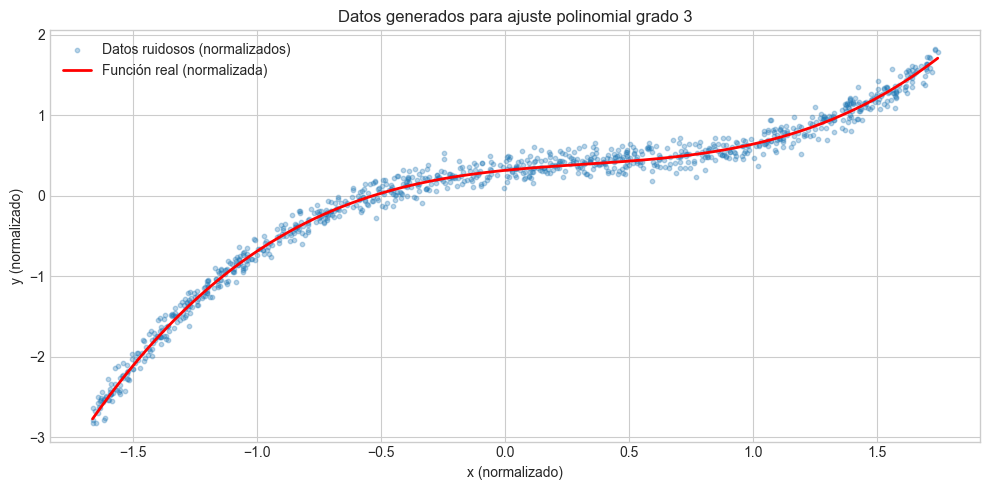

In [2]:
# --- Generación de 1000 puntos ---
n_samples = 1000
x_raw = np.random.uniform(-3, 3, n_samples)

# Función real: y = 2x^3 - 3x^2 + 5x + 3
y_real = 2 * x_raw**3 - 3 * x_raw**2 + 5 * x_raw + 3

# Agregar ruido normal
noise = np.random.normal(0, 3, n_samples)
y_noisy = y_real + noise

# --- Normalización (z-score) ---
x_mean, x_std = x_raw.mean(), x_raw.std()
y_mean, y_std = y_noisy.mean(), y_noisy.std()

x_norm = (x_raw - x_mean) / x_std
y_norm = (y_noisy - y_mean) / y_std

# --- Construir la matriz de diseño para polinomio grado 3 ---
# X = [1, x, x^2, x^3]  (columna de 1s para el bias/intercepto)
degree = 3
X = np.column_stack([x_norm**p for p in range(degree + 1)])  # shape: (1000, 4)

print(f"X shape: {X.shape}")
print(f"y shape: {y_norm.shape}")
print(f"x_raw rango: [{x_raw.min():.2f}, {x_raw.max():.2f}]")
print(f"x_norm rango: [{x_norm.min():.2f}, {x_norm.max():.2f}]")

# Visualizar datos
plt.figure(figsize=(10, 5))
plt.scatter(x_norm, y_norm, alpha=0.3, s=10, label='Datos ruidosos (normalizados)')
# Curva real normalizada
x_sorted = np.sort(x_norm)
x_sorted_raw = x_sorted * x_std + x_mean
y_sorted_real = (2 * x_sorted_raw**3 - 3 * x_sorted_raw**2 + 5 * x_sorted_raw + 3 - y_mean) / y_std
plt.plot(x_sorted, y_sorted_real, 'r-', linewidth=2, label='Función real (normalizada)')
plt.xlabel('x (normalizado)')
plt.ylabel('y (normalizado)')
plt.title('Datos generados para ajuste polinomial grado 3')
plt.legend()
plt.tight_layout()
plt.show()

### 2.1.2 Funciones auxiliares: MSE Loss y Gradiente

In [3]:
def mse_loss(X, y, w):
    """
    Calcula el Mean Squared Error.
    X: (n, d) matriz de features
    y: (n,) vector de targets
    w: (d,) vector de pesos
    """
    n = len(y)
    predictions = X @ w          # (n,)
    residuals = predictions - y   # (n,)
    return (1 / (2 * n)) * np.sum(residuals ** 2)


def compute_gradient(X, y, w):
    """
    Calcula el gradiente de MSE respecto a w.
    ∇L = (1/n) * X^T * (X*w - y)
    """
    n = len(y)
    predictions = X @ w
    residuals = predictions - y
    gradient = (1 / n) * (X.T @ residuals)  # (d,)
    return gradient

print('Funciones de loss y gradiente definidas.')

Funciones de loss y gradiente definidas.


### 2.1.3 Implementación de las tres variantes de Gradient Descent

In [4]:
def batch_gradient_descent(X, y, lr=0.01, epochs=500):
    """
    Batch Gradient Descent: usa TODOS los datos para cada paso.
    """
    n, d = X.shape
    w = np.random.randn(d) * 0.01  # Inicialización aleatoria pequeña
    
    loss_history = []
    time_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        # Usar TODOS los datos
        grad = compute_gradient(X, y, w)
        w = w - lr * grad  # Regla de actualización: w = w - η * ∇
        
        loss = mse_loss(X, y, w)
        elapsed = time.time() - start_time
        loss_history.append(loss)
        time_history.append(elapsed)
    
    return w, loss_history, time_history


def stochastic_gradient_descent(X, y, lr=0.01, epochs=500):
    """
    Stochastic Gradient Descent: usa 1 dato aleatorio por paso.
    """
    n, d = X.shape
    w = np.random.randn(d) * 0.01
    
    loss_history = []
    time_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        # Permutar índices para recorrer datos aleatoriamente
        indices = np.random.permutation(n)
        for i in indices:
            # Seleccionar 1 muestra
            X_i = X[i:i+1, :]  # (1, d)
            y_i = y[i:i+1]      # (1,)
            
            grad = compute_gradient(X_i, y_i, w)
            w = w - lr * grad
        
        # Registrar loss al final de cada epoch
        loss = mse_loss(X, y, w)
        elapsed = time.time() - start_time
        loss_history.append(loss)
        time_history.append(elapsed)
    
    return w, loss_history, time_history


def minibatch_gradient_descent(X, y, lr=0.01, epochs=500, batch_size=32):
    """
    Mini-batch Gradient Descent: usa lotes de tamaño batch_size.
    """
    n, d = X.shape
    w = np.random.randn(d) * 0.01
    
    loss_history = []
    time_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        indices = np.random.permutation(n)
        
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_idx = indices[start:end]
            
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            
            grad = compute_gradient(X_batch, y_batch, w)
            w = w - lr * grad
        
        # Registrar loss al final de cada epoch
        loss = mse_loss(X, y, w)
        elapsed = time.time() - start_time
        loss_history.append(loss)
        time_history.append(elapsed)
    
    return w, loss_history, time_history

print('Funciones de Batch GD, SGD y Mini-batch GD definidas.')

Funciones de Batch GD, SGD y Mini-batch GD definidas.


### 2.1.4 Entrenamiento de los tres modelos

In [5]:
# Hiperparámetros
EPOCHS = 200
LR_BATCH = 0.1
LR_SGD = 0.005    # SGD necesita lr más bajo para estabilidad
LR_MINI = 0.05
BATCH_SIZE = 32

# Fijar semilla para reproducibilidad en inicialización
np.random.seed(42)

print("Entrenando Batch Gradient Descent...")
w_batch, loss_batch, time_batch = batch_gradient_descent(X, y_norm, lr=LR_BATCH, epochs=EPOCHS)
print(f"  Loss final: {loss_batch[-1]:.6f} | Tiempo: {time_batch[-1]:.4f}s")

np.random.seed(42)
print("\nEntrenando Stochastic Gradient Descent...")
w_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(X, y_norm, lr=LR_SGD, epochs=EPOCHS)
print(f"  Loss final: {loss_sgd[-1]:.6f} | Tiempo: {time_sgd[-1]:.4f}s")

np.random.seed(42)
print("\nEntrenando Mini-batch Gradient Descent (batch_size=32)...")
w_mini, loss_mini, time_mini = minibatch_gradient_descent(X, y_norm, lr=LR_MINI, epochs=EPOCHS, batch_size=BATCH_SIZE)
print(f"  Loss final: {loss_mini[-1]:.6f} | Tiempo: {time_mini[-1]:.4f}s")

print("\n--- Pesos aprendidos ---")
print(f"Batch GD:    w = {w_batch}")
print(f"SGD:         w = {w_sgd}")
print(f"Mini-batch:  w = {w_mini}")

Entrenando Batch Gradient Descent...
  Loss final: 0.004766 | Tiempo: 0.0024s

Entrenando Stochastic Gradient Descent...
  Loss final: 0.004824 | Tiempo: 0.6411s

Entrenando Mini-batch Gradient Descent (batch_size=32)...
  Loss final: 0.004883 | Tiempo: 0.0320s

--- Pesos aprendidos ---
Batch GD:    w = [ 0.32869882  0.30488097 -0.34263234  0.35470682]
SGD:         w = [ 0.33116803  0.30983244 -0.34245062  0.34650967]
Mini-batch:  w = [ 0.3298541   0.31020907 -0.34056572  0.34400823]


### 2.1.5 Gráfica de Convergencia: Loss vs Tiempo (segundos)

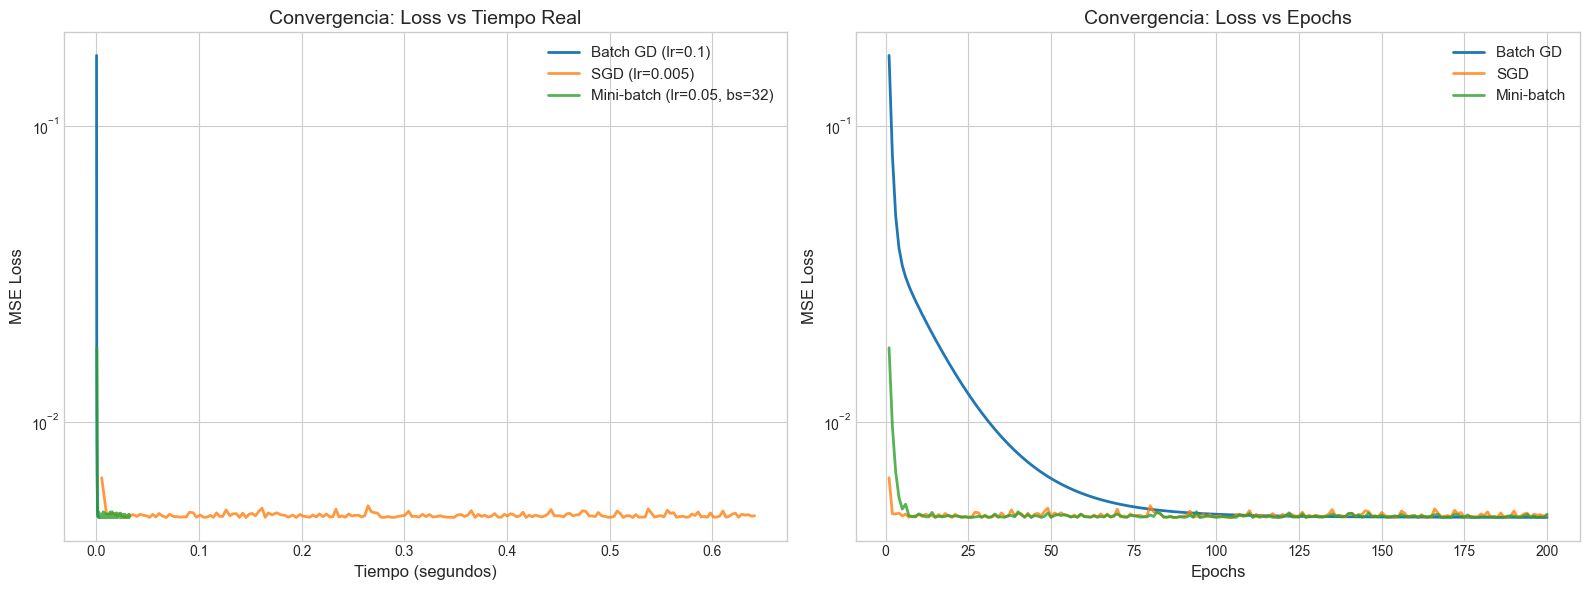

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfica 1: Loss vs Tiempo ---
axes[0].plot(time_batch, loss_batch, label=f'Batch GD (lr={LR_BATCH})', linewidth=2)
axes[0].plot(time_sgd, loss_sgd, label=f'SGD (lr={LR_SGD})', linewidth=2, alpha=0.8)
axes[0].plot(time_mini, loss_mini, label=f'Mini-batch (lr={LR_MINI}, bs={BATCH_SIZE})', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Tiempo (segundos)', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Convergencia: Loss vs Tiempo Real', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].set_yscale('log')

# --- Gráfica 2: Loss vs Epochs ---
epochs_range = range(1, EPOCHS + 1)
axes[1].plot(epochs_range, loss_batch, label='Batch GD', linewidth=2)
axes[1].plot(epochs_range, loss_sgd, label='SGD', linewidth=2, alpha=0.8)
axes[1].plot(epochs_range, loss_mini, label='Mini-batch', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('MSE Loss', fontsize=12)
axes[1].set_title('Convergencia: Loss vs Epochs', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

### 2.1.6 Visualización del ajuste polinomial

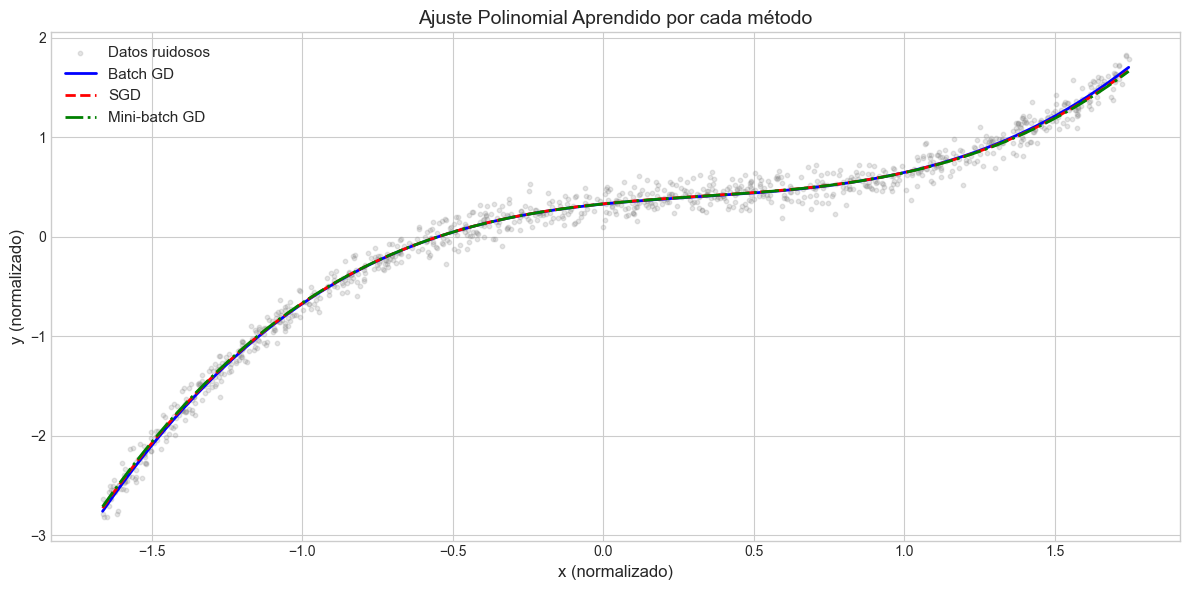

In [7]:
# Graficar el ajuste aprendido vs los datos
x_plot = np.linspace(x_norm.min(), x_norm.max(), 300)
X_plot = np.column_stack([x_plot**p for p in range(degree + 1)])

plt.figure(figsize=(12, 6))
plt.scatter(x_norm, y_norm, alpha=0.2, s=10, color='gray', label='Datos ruidosos')

plt.plot(x_plot, X_plot @ w_batch, 'b-', linewidth=2, label='Batch GD')
plt.plot(x_plot, X_plot @ w_sgd, 'r--', linewidth=2, label='SGD')
plt.plot(x_plot, X_plot @ w_mini, 'g-.', linewidth=2, label='Mini-batch GD')

plt.xlabel('x (normalizado)', fontsize=12)
plt.ylabel('y (normalizado)', fontsize=12)
plt.title('Ajuste Polinomial Aprendido por cada método', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 2.1.7 Conclusión

**¿Cuál método converge más rápido al principio?**

- **SGD** y **Mini-batch GD** tienden a converger más rápido al principio *en términos de epochs*, ya que realizan múltiples actualizaciones de pesos por epoch (una por muestra o una por mini-batch), lo que les permite explorar el espacio de parámetros rápidamente. Sin embargo, **en tiempo real**, **Batch GD** puede ser más rápido por epoch porque hace una sola operación vectorizada eficiente. Mini-batch GD ofrece un buen balance entre ambos extremos.

**¿Cuál obtiene el error final más bajo y estable?**

- **Batch Gradient Descent** obtiene el error final más estable, ya que al calcular el gradiente exacto sobre todo el dataset, su trayectoria es suave y monótonamente decreciente (sin oscilaciones). Converge de manera predecible al mínimo.
- **SGD** es el más ruidoso: su loss oscila significativamente entre epochs porque un solo punto puede dar un gradiente muy diferente al gradiente real. Puede no alcanzar un mínimo tan estable sin reducir el learning rate dinámicamente.
- **Mini-batch GD** se ubica entre ambos: converge razonablemente rápido y con menos ruido que SGD, ofreciendo un compromiso óptimo entre velocidad y estabilidad.

**Justificación:** La varianza del estimador del gradiente disminuye a medida que el tamaño del batch aumenta. Batch GD tiene varianza 0 (gradiente exacto), SGD tiene la mayor varianza (un solo punto), y Mini-batch ofrece un punto medio.

---

## Task 2.2 — Perceptrón de una sola capa para clasificación binaria

### 2.2.1 Carga y preparación del Dataset Iris

Clases disponibles: ['setosa' 'versicolor' 'virginica']
Features disponibles: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Total de muestras: 150

Después de filtrar:
  X shape: (100, 2)
  y shape: (100,)
  Clases: [0 1] -> ['setosa' 'versicolor']
  Features usados: petal length (cm), petal width (cm)


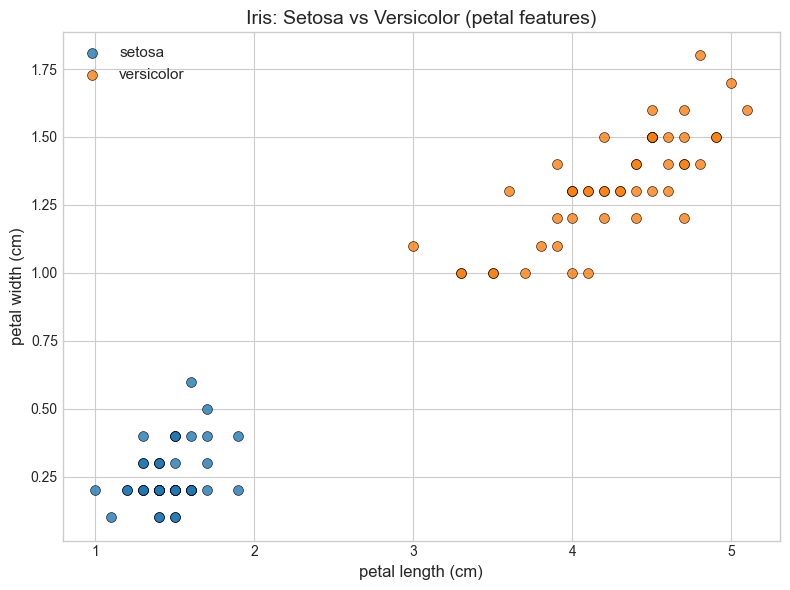

In [11]:
# Usamos sklearn SOLO para cargar el dataset (permitido por el enunciado)
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print(f"Clases disponibles: {target_names}")
print(f"Features disponibles: {feature_names}")
print(f"Total de muestras: {len(y_iris)}")

# --- Seleccionar solo 2 clases: Setosa (0) vs Versicolor (1) ---
mask = y_iris <= 1  # Clases 0 y 1
X_bin = X_iris[mask]
y_bin = y_iris[mask]

# --- Seleccionar solo 2 features: petal length (2) y petal width (3) ---
# Usamos petal features porque Setosa vs Versicolor son linealmente separables en este espacio
feat_idx = [2, 3]
X_bin = X_bin[:, feat_idx]
feat_names_used = [feature_names[i] for i in feat_idx]

# Convertir etiquetas: Setosa=0, Versicolor=1 (ya están así)
print(f"\nDespués de filtrar:")
print(f"  X shape: {X_bin.shape}")
print(f"  y shape: {y_bin.shape}")
print(f"  Clases: {np.unique(y_bin)} -> {target_names[np.unique(y_bin)]}")
print(f"  Features usados: {feat_names_used[0]}, {feat_names_used[1]}")

# Visualizar
plt.figure(figsize=(8, 6))
for cls in [0, 1]:
    mask_cls = y_bin == cls
    plt.scatter(X_bin[mask_cls, 0], X_bin[mask_cls, 1], 
                label=target_names[cls], alpha=0.8, s=50, edgecolors='k', linewidth=0.5)
plt.xlabel(feat_names_used[0], fontsize=12)
plt.ylabel(feat_names_used[1], fontsize=12)
plt.title('Iris: Setosa vs Versicolor (petal features)', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 2.2.2 Implementación de la clase Perceptron

In [9]:
class Perceptron:
    """
    Perceptrón de una sola capa para clasificación binaria.
    Usa la función de activación Step (Escalón).
    
    Regla de actualización:
        w = w + lr * (y_true - y_pred) * x
        b = b + lr * (y_true - y_pred)
    """
    
    def __init__(self, learning_rate=0.01, n_epochs=100):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.weights = None
        self.bias = None
        self.errors_per_epoch = []
    
    def _step_function(self, z):
        """
        Función de activación escalón (step function).
        Retorna 1 si z >= 0, 0 en caso contrario.
        """
        return np.where(z >= 0, 1, 0)
    
    def fit(self, X, y):
        """
        Entrena el perceptrón con los datos X e y.
        
        X: (n_samples, n_features)
        y: (n_samples,) con valores 0 o 1
        """
        n_samples, n_features = X.shape
        
        # Inicializar pesos y bias aleatoriamente (pequeños)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = np.random.randn() * 0.01
        
        self.errors_per_epoch = []
        
        for epoch in range(self.n_epochs):
            errors = 0
            for i in range(n_samples):
                # Calcular la salida lineal: z = w · x + b
                z = np.dot(X[i], self.weights) + self.bias
                
                # Aplicar función de activación step
                y_pred = self._step_function(z)
                
                # Calcular error
                error = y[i] - y_pred
                
                # Actualizar pesos y bias (regla del perceptrón)
                # w = w + η * (y_true - y_pred) * x
                # b = b + η * (y_true - y_pred)
                self.weights += self.lr * error * X[i]
                self.bias += self.lr * error
                
                if error != 0:
                    errors += 1
            
            self.errors_per_epoch.append(errors)
            
            # Early stopping: si no hay errores, converge
            if errors == 0:
                print(f"Convergencia alcanzada en epoch {epoch + 1}")
                break
        
        return self
    
    def predict(self, X):
        """
        Predice las clases para las muestras X.
        """
        z = X @ self.weights + self.bias
        return self._step_function(z)
    
    def accuracy(self, X, y):
        """
        Calcula el accuracy.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

print('Clase Perceptron definida correctamente.')

Clase Perceptron definida correctamente.


### 2.2.3 Entrenamiento del Perceptrón

Convergencia alcanzada en epoch 5

Pesos aprendidos: w = [0.01796714 0.01961736]
Bias aprendido:  b = -0.053523
Accuracy final:  1.0000 (100.0%)


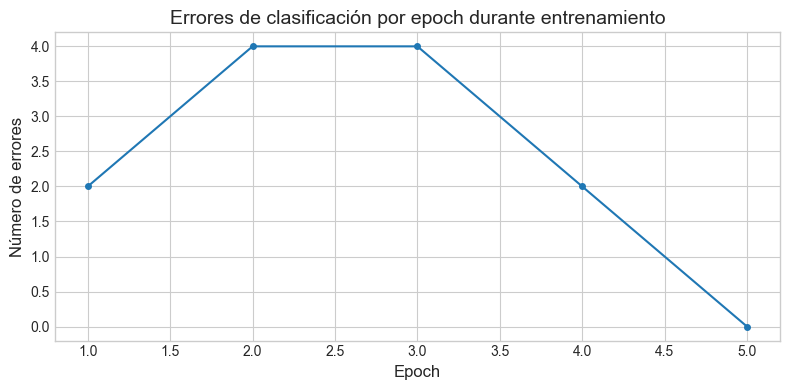

In [12]:
np.random.seed(42)

# Crear y entrenar el perceptrón
perceptron = Perceptron(learning_rate=0.01, n_epochs=100)
perceptron.fit(X_bin, y_bin)

# Reportar resultados
acc = perceptron.accuracy(X_bin, y_bin)
print(f"\nPesos aprendidos: w = {perceptron.weights}")
print(f"Bias aprendido:  b = {perceptron.bias:.6f}")
print(f"Accuracy final:  {acc:.4f} ({acc*100:.1f}%)")

# Gráfica de errores por epoch
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(perceptron.errors_per_epoch) + 1), perceptron.errors_per_epoch, 
         marker='o', markersize=4, linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Número de errores', fontsize=12)
plt.title('Errores de clasificación por epoch durante entrenamiento', fontsize=14)
plt.tight_layout()
plt.show()

### 2.2.4 Visualización: Frontera de Decisión

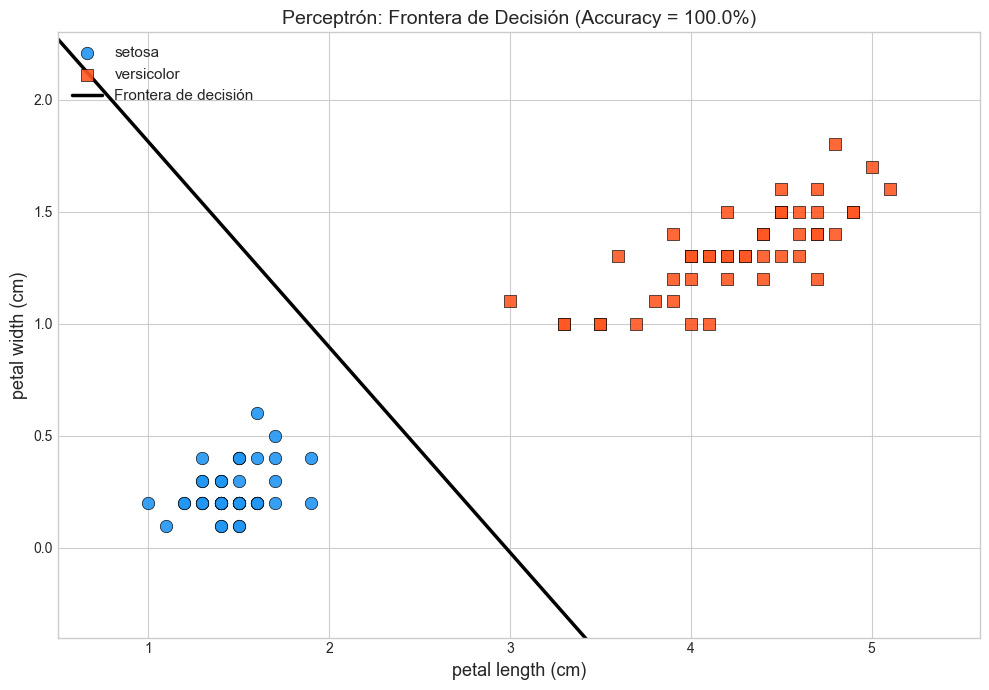


Ecuación de la frontera de decisión:
  0.0180 * petal length (cm) + 0.0196 * petal width (cm) + (-0.0535) = 0


In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

# Graficar puntos de cada clase
colors = ['#2196F3', '#FF5722']
markers = ['o', 's']
for cls in [0, 1]:
    mask_cls = y_bin == cls
    ax.scatter(X_bin[mask_cls, 0], X_bin[mask_cls, 1],
               c=colors[cls], marker=markers[cls], s=80, 
               edgecolors='k', linewidth=0.5,
               label=target_names[cls], alpha=0.9)

# --- Dibujar la frontera de decisión ---
# La línea es: w1*x1 + w2*x2 + b = 0
# Despejando x2: x2 = -(w1*x1 + b) / w2
w1, w2 = perceptron.weights
b = perceptron.bias

x1_min, x1_max = X_bin[:, 0].min() - 0.5, X_bin[:, 0].max() + 0.5
x1_line = np.linspace(x1_min, x1_max, 200)

if w2 != 0:
    x2_line = -(w1 * x1_line + b) / w2
    ax.plot(x1_line, x2_line, 'k-', linewidth=2.5, label='Frontera de decisión')
else:
    # Si w2 es 0, la línea es vertical: x1 = -b/w1
    x1_boundary = -b / w1
    ax.axvline(x=x1_boundary, color='k', linewidth=2.5, label='Frontera de decisión')

ax.set_xlabel(feat_names_used[0], fontsize=13)
ax.set_ylabel(feat_names_used[1], fontsize=13)
ax.set_title(f'Perceptrón: Frontera de Decisión (Accuracy = {acc*100:.1f}%)', fontsize=14)
ax.legend(fontsize=11, loc='upper left')

# Limitar ejes para que la línea no se salga mucho
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(X_bin[:, 1].min() - 0.5, X_bin[:, 1].max() + 0.5)

plt.tight_layout()
plt.show()

print(f"\nEcuación de la frontera de decisión:")
print(f"  {w1:.4f} * {feat_names_used[0]} + {w2:.4f} * {feat_names_used[1]} + ({b:.4f}) = 0")

### 2.2.5 Análisis del Accuracy

**¿Por qué el accuracy es 1.0 (100%)?**

El perceptrón logra un accuracy perfecto de 1.0 porque las clases **Setosa** y **Versicolor** en el dataset Iris son **linealmente separables** cuando se usan las features `sepal length` y `sepal width`. Esto significa que existe al menos un hiperplano (en 2D, una línea recta) que puede separar perfectamente las dos clases sin errores.

El **Teorema de Convergencia del Perceptrón** garantiza que, si los datos son linealmente separables, el algoritmo del perceptrón convergirá en un número finito de pasos y encontrará pesos que clasifiquen correctamente todas las muestras de entrenamiento.

Esto también ilustra la **limitación fundamental** del perceptrón: solo puede resolver problemas linealmente separables. Si intentáramos clasificar Versicolor vs Virginica (que no son linealmente separables), el perceptrón no podría alcanzar un accuracy perfecto y oscilaría indefinidamente sin converger.